In [1]:
import numpy as np
import tensorflow as tf
import numpy as np
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.callbacks import EarlyStopping

from IPython import display
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from livelossplot import PlotLosses
plt.gray()

#DEAP
from deap import algorithms
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

<Figure size 432x288 with 0 Axes>

Load Fashion Data

In [2]:
# load dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

Setup class names and labels for visualization, not training

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Plot some images.

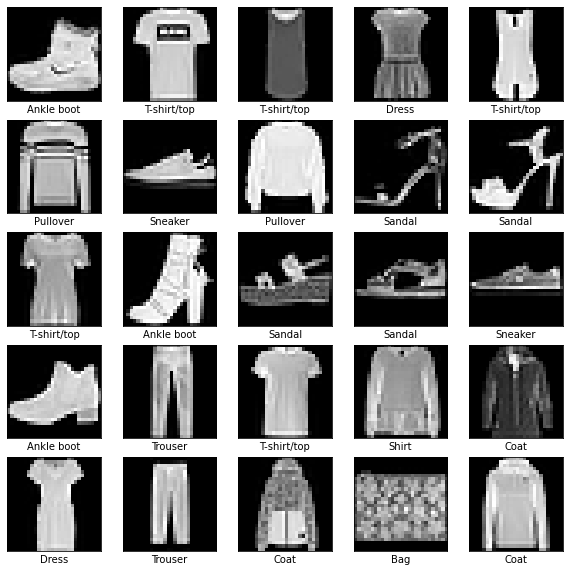

In [4]:
import math

def plot_data(num_images, images, labels):
  grid = math.ceil(math.sqrt(num_images))
  plt.figure(figsize=(grid*2,grid*2))
  for i in range(num_images):
      plt.subplot(grid,grid,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)     
      plt.imshow(images[i].reshape(28,28))
      plt.xlabel(class_names[labels[i]])      
  plt.show()

plot_data(25, train_images, train_labels)


STAGE 1: Auto-encoders

Build the Encoder

In [ ]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = layers.MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = layers.MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = layers.MaxPool2D( (2, 2), padding='same')(encoded_layer3)

Build the Decoder

In [ ]:
#decoding architecture
decoded_layer1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = layers.UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = layers.UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = layers.Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = layers.UpSampling2D((2, 2))(decoded_layer3)
#output layer
output_layer   = layers.Conv2D(1, (3, 3), padding='same')(decoded_layer3)

Build the Model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624  

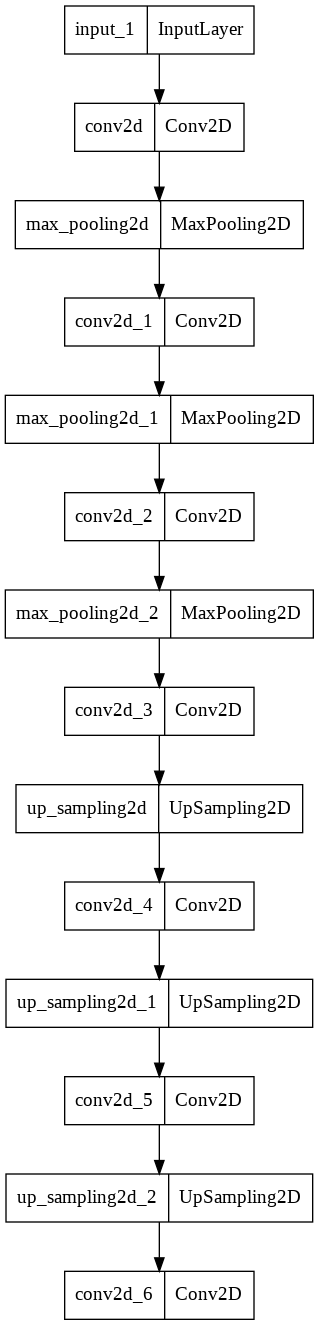

In [ ]:
# compile the model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()
plot_model(model)

In [5]:
history_loss = []
history_val_loss = []

def add_history(history):
  history_loss.append(history.history["loss"])
  history_val_loss.append(history.history["val_loss"])

def reset_history():
  global history_loss
  global history_val_loss
  history_loss = []
  history_val_loss = []
  return []

def plot_results(num_images, images, labels, history):
  add_history(history)
  grid = math.ceil(math.sqrt(num_images))
  plt.figure(figsize=(grid*2,grid*2))
  for i in range(num_images):
      plt.subplot(grid,grid,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)     
      plt.imshow(images[i].reshape(28,28))
      plt.xlabel(class_names[labels[i]])      
  plt.show()
  plt.plot(history_loss, label='loss')
  plt.plot(history_val_loss, label='val_loss')
  plt.legend()
  plt.show()  

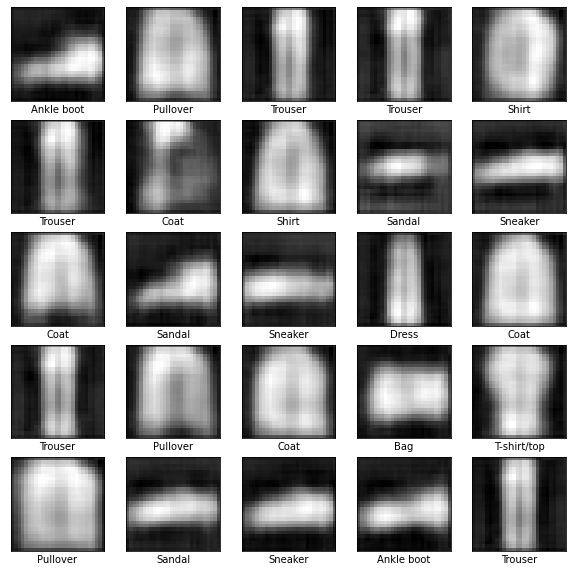

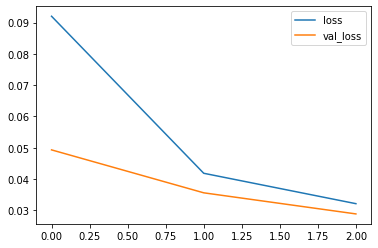

In [ ]:
EPOCHS = 3
history = reset_history()

for i in range(EPOCHS):
  history = model.fit(train_images, train_images, epochs=1, batch_size=2048, validation_data=(test_images, test_images))
  pred_images = model.predict(test_images[:25])
  clear_output()
  plot_results(25, pred_images[:25], test_labels[:25], history)

In [6]:
#@title Constants
max_layers = 10
max_neurons = 128
min_neurons = 16
max_kernel = 3
min_kernel = 3
max_pool = 2
min_pool = 2

CONV_LAYER = -1
CONV_LAYER_LEN = 4
BN_LAYER = -3
BN_LAYER_LEN = 1
DROPOUT_LAYER = -4
DROPOUT_LAYER_LEN = 2
UPCONV_LAYER = -2
UPCONV_LAYER_LEN = 4

In [7]:
#@title Encoding scheme
def generate_neurons():
  return random.randint(min_neurons, max_neurons)

def generate_kernel():
  part = []
  part.append(random.randint(min_kernel, max_kernel))
  part.append(random.randint(min_kernel, max_kernel))
  return part

def generate_bn_layer():
  part = [BN_LAYER] 
  return part

def generate_dropout_layer():
  part = [DROPOUT_LAYER] 
  part.append(random.uniform(0,.5))  
  return part

def generate_conv_layer():
  part = [CONV_LAYER] 
  part.append(generate_neurons())
  part.extend(generate_kernel())  
  return part

def generate_upconv_layer():
  part = [UPCONV_LAYER] 
  part.append(generate_neurons())
  part.extend(generate_kernel())  
  return part

def create_offspring():
  ind = []
  layers = 0
  for i in range(max_layers):
    if i==0: #first layer always convolutational
      ind.extend(generate_conv_layer())      
      layers += 1
    elif random.uniform(0,1)<.5:
      #add convolution layer
      ind.extend(generate_conv_layer())
      layers += 1
      if random.uniform(0,1)<.5:
        #add batchnormalization
        ind.extend(generate_bn_layer())
      if random.uniform(0,1) < .5:
        ind.extend(generate_dropout_layer()) 
  for i in range(layers):
    ind.extend(generate_upconv_layer())
    if random.uniform(0,1)<.5:
      #add batchnormalization
      ind.extend(generate_bn_layer())
    if random.uniform(0,1) < .5:
      ind.extend(generate_dropout_layer())
  return ind
        
individual = create_offspring()
print(individual)

[-1, 56, 3, 3, -1, 92, 3, 3, -1, 68, 3, 3, -1, 30, 3, 3, -3, -4, 0.0008871699753961737, -1, 61, 3, 3, -3, -1, 31, 3, 3, -1, 117, 3, 3, -3, -4, 0.14323422662844454, -2, 109, 3, 3, -3, -4, 0.11931085840056443, -2, 22, 3, 3, -3, -4, 0.3502780323797578, -2, 80, 3, 3, -3, -4, 0.1763909416946559, -2, 117, 3, 3, -3, -4, 0.26924011791410396, -2, 77, 3, 3, -2, 108, 3, 3, -2, 28, 3, 3, -4, 0.1497028976615578]


In [8]:
def padding(gene):
  return "same" if gene == 1 else "valid"

def build_model(individual):
  input_layer = Input(shape=(28, 28, 1))  
  il = len(individual)
  i = 0
  x = input_layer
  while i < il:    
    if individual[i] == CONV_LAYER:      
      pad="same" 
      n = individual[i+1]
      k = (individual[i+2], individual[i+3])
      i += CONV_LAYER_LEN        
      x = layers.Conv2D(n, k, activation='relu', padding=pad)(x) 
      if x.shape[1] > 7:
        x = layers.MaxPool2D( (2, 2), padding='same')(x)
    elif individual[i] == BN_LAYER: #add batchnormal layer
      x = layers.BatchNormalization()(x)
      i += BN_LAYER_LEN      
    elif individual[i] == DROPOUT_LAYER: #add dropout layer            
      x = layers.Dropout(individual[i+1])(x) 
      i += DROPOUT_LAYER_LEN
    elif individual[i] == UPCONV_LAYER:
      pad="same"
      n = individual[i+1]
      k = (individual[i+2], individual[i+3])        
      x = layers.Conv2D(n, k, activation='relu', padding=pad)(x)   
      x = layers.UpSampling2D((2, 2))(x)   
      i += CONV_LAYER_LEN   
      if x.shape[1] == (28):
        break #model is complete
    else:
      break
  if x.shape[1] == 14:
    x = layers.UpSampling2D((2, 2))(x)
    
  output_layer = layers.Conv2D(1, (3, 3), padding='same')(x)
  model = Model(input_layer, output_layer)
  model.compile(optimizer='adam', loss='mse')
  return model

model = build_model(individual) 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 56)        560       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 56)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 92)        46460     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 92)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 68)          56372 

In [9]:
individual = create_offspring() 
model = build_model(individual)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 39)        390       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 39)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 39)        13728     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 39)          0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 39)          0   

# Creating Mate/Mutation Operators

In [10]:
#@title Start of Mate/Mutation Operators
def get_layers(ind, layer_type):
  return [a for a in range(len(ind)) if ind[a] == layer_type]

def swap(ind1, iv1, ind2, iv2, ll):
  ch1 = ind1[iv1:iv1+ll]
  ch2 = ind2[iv2:iv2+ll] 
  ind1[iv1:iv1+ll] = ch2
  ind2[iv2:iv2+ll] = ch1
  return ind1, ind2

def swap_layers(ind1, ind2, layer_type, layer_len):
  c1, c2 = get_layers(ind1, layer_type), get_layers(ind2, layer_type) 
  min_c = min(len(c1), len(c2))
  for i in range(min_c):
    if random.random() < 1:
      i1 = random.randint(0, len(c1)-1)
      i2 = random.randint(0, len(c2)-1)      
      iv1 = c1.pop(i1)
      iv2 = c2.pop(i2)    
      ind1, ind2 = swap(ind1, iv1, ind2, iv2, layer_len) 
  return ind1, ind2 

def crossover(ind1, ind2):  
  ind1, ind2 = swap_layers(ind1, ind2, CONV_LAYER, CONV_LAYER_LEN)
  ind1, ind2 = swap_layers(ind1, ind2, UPCONV_LAYER, UPCONV_LAYER_LEN)
  ind1, ind2 = swap_layers(ind1, ind2, BN_LAYER, BN_LAYER_LEN)
  ind1, ind2 = swap_layers(ind1, ind2, DROPOUT_LAYER, DROPOUT_LAYER_LEN)
  return ind1, ind2  

ind1 = create_offspring()
ind2 = create_offspring()
print(ind1)
print(ind2)

ind1, ind2 = crossover(ind1, ind2)
print(ind1)
print(ind2)

model = build_model(ind1)
model.summary()
model = build_model(ind2)
model.summary()

[-1, 26, 3, 3, -1, 105, 3, 3, -3, -4, 0.15097387215227492, -1, 96, 3, 3, -3, -4, 0.2947876416608423, -1, 16, 3, 3, -3, -1, 21, 3, 3, -3, -2, 128, 3, 3, -4, 0.44163889741051726, -2, 72, 3, 3, -2, 95, 3, 3, -2, 87, 3, 3, -4, 0.19717488418923368, -2, 73, 3, 3, -3]
[-1, 69, 3, 3, -1, 75, 3, 3, -4, 0.45840516531288084, -1, 72, 3, 3, -3, -1, 48, 3, 3, -4, 0.23523748104160358, -1, 50, 3, 3, -4, 0.3648210296347824, -1, 122, 3, 3, -2, 80, 3, 3, -4, 0.15599760422543568, -2, 27, 3, 3, -4, 0.3745834081561377, -2, 23, 3, 3, -2, 41, 3, 3, -3, -2, 101, 3, 3, -3, -2, 43, 3, 3, -4, 0.12344489598731895]
[-1, 72, 3, 3, -1, 75, 3, 3, -3, -4, 0.3745834081561377, -1, 50, 3, 3, -3, -4, 0.45840516531288084, -1, 69, 3, 3, -3, -1, 48, 3, 3, -3, -2, 101, 3, 3, -4, 0.12344489598731895, -2, 27, 3, 3, -2, 41, 3, 3, -2, 43, 3, 3, -4, 0.15599760422543568, -2, 23, 3, 3, -3]
[-1, 16, 3, 3, -1, 105, 3, 3, -4, 0.2947876416608423, -1, 26, 3, 3, -3, -1, 21, 3, 3, -4, 0.23523748104160358, -1, 96, 3, 3, -4, 0.364821029634782

In [11]:
#@title Mutation
def mutate(part, layer_type):
  if layer_type == CONV_LAYER and len(part)==CONV_LAYER_LEN:
    part[1] = int(part[1] * random.uniform(.9, 1.1))
    part[2] = random.randint(min_kernel, max_kernel)
    part[3] = random.randint(min_kernel, max_kernel)
  elif layer_type == UPCONV_LAYER and len(part)==UPCONV_LAYER_LEN:
    part[1] = random.randint(min_kernel, max_kernel)
    part[2] = random.randint(min_kernel, max_kernel)
  elif layer_type == DROPOUT_LAYER and len(part)==DROPOUT_LAYER_LEN:
    part[1] = random.uniform(0, .5) 
  else:
    error = f"mutate ERROR {part}"    
    raise Exception(error) 
  return part

def mutate_layers(ind, layer_type, layer_len):
  layers = get_layers(ind1, layer_type)
  for layer in layers:
    if random.random() < 1:
      try:
        ind[layer:layer+layer_len] = mutate(
            ind[layer:layer+layer_len], layer_type) 
      except:
        print(layers)
  return ind      

print(ind1)

def mutation(ind):    
  ind = mutate_layers(ind, CONV_LAYER, CONV_LAYER_LEN)
  ind = mutate_layers(ind, DROPOUT_LAYER, DROPOUT_LAYER_LEN)    
  ind = mutate_layers(ind, UPCONV_LAYER, UPCONV_LAYER_LEN)
  return ind,

ind, = mutation(ind1)
print(ind)
model = build_model(ind1)
model.summary()

[-1, 72, 3, 3, -1, 75, 3, 3, -3, -4, 0.3745834081561377, -1, 50, 3, 3, -3, -4, 0.45840516531288084, -1, 69, 3, 3, -3, -1, 48, 3, 3, -3, -2, 101, 3, 3, -4, 0.12344489598731895, -2, 27, 3, 3, -2, 41, 3, 3, -2, 43, 3, 3, -4, 0.15599760422543568, -2, 23, 3, 3, -3]
[-1, 78, 3, 3, -1, 79, 3, 3, -3, -4, 0.10393918150792214, -1, 45, 3, 3, -3, -4, 0.37139821214375085, -1, 74, 3, 3, -3, -1, 50, 3, 3, -3, -2, 3, 3, 3, -4, 0.29000590240882396, -2, 3, 3, 3, -2, 3, 3, 3, -2, 3, 3, 3, -4, 0.15216081014705135, -2, 3, 3, 3, -3]
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 78)        780       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 78)        0         
 g2D

In [12]:
#@title Setting up the Creator
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [13]:
#@title Create Individual and Population
toolbox = base.Toolbox()
toolbox.register("autoencoder", create_offspring)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.autoencoder)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("select", tools.selTournament, tournsize=5)

In [14]:
#@title Register Crossover and Mutation
toolbox.register("mate", crossover)
toolbox.register("mutate", mutation)

In [15]:
#@title Register Evaluation
def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)

def train(model):  
  model.fit(train_images, train_images, epochs=3,                     
                    verbose=0)
  return model

max_fitness = 0

def evaluate(individual):  
  try:
    model = build_model(individual)
    model = train(model)    
    eval = model.evaluate(test_images, test_images, verbose=0)
    print(".", end='')
    
    return clamp(eval, 0, 1000),
  except:
    return 1000,  

toolbox.register("evaluate", evaluate)  

In [16]:
#@title Optimize the Weights { run: "auto" }
MU = 5 #@param {type:"slider", min:5, max:1000, step:5}
NGEN = 5 #@param {type:"slider", min:5, max:100, step:1}
RGEN = 1 #@param {type:"slider", min:1, max:100, step:1}
CXPB = .6
MUTPB = .3

random.seed(64)

pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

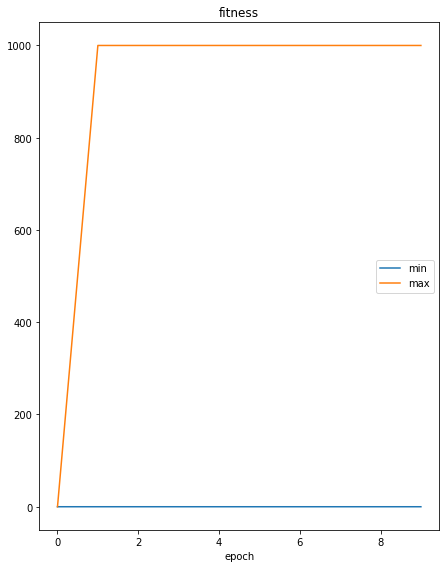

fitness
	min              	 (min:    0.005, max:    0.006, cur:    0.005)
	max              	 (min:    0.010, max: 1000.000, cur: 1000.000)


In [17]:
best = None
groups = { "fitness" : {"min", "max"}}
plotlosses = PlotLosses(groups=groups)

for g in range(NGEN):
  pop, logbook = algorithms.eaSimple(pop, toolbox, 
            cxpb=CXPB, mutpb=MUTPB, ngen=RGEN, stats=stats, halloffame=hof, verbose=False)
  best = hof[0] 
  
  print(f"Gen ({(g+1)*RGEN})")      
  for l in logbook:
    plotlosses.update({'min': l["min"], 'max': l["max"]})
  plotlosses.send()  # draw, update logs, etc